In [1]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
#import pims  # image reading routines
import os

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
from scipy import ndimage  # for shifting images
#from pims import pipeline
#from pims import Frame
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate


#%load_ext autoreload
#%autoreload 2

#from track_lib import  *

from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)


#Acceleration integrator
def find_baseline(channel):
    sum = 0
    for i in range(10000):
        sum += channel[i]
    return sum/10000

conv = 1#981/0.3 #should this be 0.55?

def integrate_accel(channel, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(Time.size-1):
        dv = 0.5*(conv*(channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def sub_integrate_vel(channel, lower, higher, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(lower, higher):
        dv = 0.5*((channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def differentiate(data, f_p_s):
    dx = np.zeros(data.size)
    for i in range(dx.size-1):
        dx[i] = (data[i+1]-data[i])*f_p_s
    return dx


In [125]:
#8cm data
accel_xdata1 = pd.read_csv('SR8-ax.csv')
accel_ydata1 = pd.read_csv('SR8-ay.csv')

accel_xdata2 = pd.read_csv('SR8-bx.csv')
accel_ydata2 = pd.read_csv('SR8-by.csv')

accel_xdata3 = pd.read_csv('SR8-cx.csv')
accel_ydata3 = pd.read_csv('SR8-cy.csv')
#12cm data
accel_xdata4 = pd.read_csv('SR12-ax.csv')
accel_ydata4 = pd.read_csv('SR12-ay.csv')

accel_xdata5 = pd.read_csv('SR12-bx.csv')
accel_ydata5 = pd.read_csv('SR12-by.csv')

accel_xdata6 = pd.read_csv('SR12-cx.csv')
accel_ydata6 = pd.read_csv('SR12-cy.csv')

In [126]:
#ignore channel C for 8cm data
accel_xdata1

,Time,Channel A,Channel B,Channel C,Channel D,Channel H
0,(ms),(V),(V),(V),(V),(V)
1,-99.99339283,1.60587800,1.58802300,1.61244000,1.59840100,7.11176900
2,-99.98339283,1.60313100,1.59077000,1.61244000,1.60099500,7.12764000
3,-99.97339283,1.60587800,1.58802300,1.61244000,1.60099500,7.11176900
4,-99.96339283,1.60313100,1.58802300,1.60969400,1.59840100,7.12764000
...,...,...,...,...,...,...
100000,899.99658191,1.60587800,1.58802300,1.60969400,1.59840100,7.12245100
100001,900.00658191,1.60313100,1.58802300,1.61244000,1.60099500,7.11176900
100002,900.01658191,1.60313100,1.58802300,1.61244000,1.60099500,7.11695800
100003,900.02658191,1.60313100,1.59077000,1.60969400,1.59840100,7.09559200


In [127]:
Timex = np.zeros(accel_xdata1.loc[1:,"Time"].size)
Timex[:] = np.array(accel_xdata1.loc[1:,"Time"])
Timex = Timex/1000

Timey = np.zeros(accel_xdata4.loc[1:,"Time"].size)
Timey[:] = np.array(accel_xdata4.loc[1:,"Time"])
Timey = Timey/1000

Accel_data8 = np.zeros((2,3,3,accel_xdata1.loc[1:,"Time"].size)) #x or y, 3 datasets, 3 channels, data for each cannel
Accel_data12 = np.zeros((2,3,3,accel_xdata1.loc[1:,"Time"].size)) #3 datasets, 3 channels, data for each cannel

#load 8cm x data
Accel_data8[0,0,0,:] = np.array(accel_xdata1.loc[1:,"Channel A"])
Accel_data8[0,0,1,:] = np.array(accel_xdata1.loc[1:,"Channel B"])
Accel_data8[0,0,2,:] = np.array(accel_xdata1.loc[1:,"Channel D"])

Accel_data8[0,1,0,:] = np.array(accel_xdata2.loc[1:,"Channel A"])
Accel_data8[0,1,1,:] = np.array(accel_xdata2.loc[1:,"Channel B"])
Accel_data8[0,1,2,:] = np.array(accel_xdata2.loc[1:,"Channel D"])

Accel_data8[0,2,0,:] = np.array(accel_xdata3.loc[1:,"Channel A"])
Accel_data8[0,2,1,:] = np.array(accel_xdata3.loc[1:,"Channel B"])
Accel_data8[0,2,2,:] = np.array(accel_xdata3.loc[1:,"Channel D"])

#load 8 cm y data
Accel_data8[1,0,0,:] = np.array(accel_ydata1.loc[1:,"Channel A"])
Accel_data8[1,0,1,:] = np.array(accel_ydata1.loc[1:,"Channel B"])
Accel_data8[1,0,2,:] = np.array(accel_ydata1.loc[1:,"Channel D"])

Accel_data8[1,1,0,:] = np.array(accel_ydata2.loc[1:,"Channel A"])
Accel_data8[1,1,1,:] = np.array(accel_ydata2.loc[1:,"Channel B"])
Accel_data8[1,1,2,:] = np.array(accel_ydata2.loc[1:,"Channel D"])

Accel_data8[1,2,0,:] = np.array(accel_ydata3.loc[1:,"Channel A"])
Accel_data8[1,2,1,:] = np.array(accel_ydata3.loc[1:,"Channel B"])
Accel_data8[1,2,2,:] = np.array(accel_ydata3.loc[1:,"Channel D"])

#load 12 cm x data
Accel_data12[0,0,0,:] = np.array(accel_xdata4.loc[1:,"Channel A"])
Accel_data12[0,0,1,:] = np.array(accel_xdata4.loc[1:,"Channel B"])
Accel_data12[0,0,2,:] = np.array(accel_xdata4.loc[1:,"Channel C"])

Accel_data12[0,1,0,:] = np.array(accel_xdata5.loc[1:,"Channel A"])
Accel_data12[0,1,1,:] = np.array(accel_xdata5.loc[1:,"Channel B"])
Accel_data12[0,1,2,:] = np.array(accel_xdata5.loc[1:,"Channel C"])

Accel_data12[0,2,0,:] = np.array(accel_xdata6.loc[1:,"Channel A"])
Accel_data12[0,2,1,:] = np.array(accel_xdata6.loc[1:,"Channel B"])
Accel_data12[0,2,2,:] = np.array(accel_xdata6.loc[1:,"Channel C"])

#load 12 cm y data
Accel_data12[1,0,0,:] = np.array(accel_ydata4.loc[1:,"Channel A"])
Accel_data12[1,0,1,:] = np.array(accel_ydata4.loc[1:,"Channel B"])
Accel_data12[1,0,2,:] = np.array(accel_ydata4.loc[1:,"Channel C"])

Accel_data12[1,1,0,:] = np.array(accel_ydata5.loc[1:,"Channel A"])
Accel_data12[1,1,1,:] = np.array(accel_ydata5.loc[1:,"Channel B"])
Accel_data12[1,1,2,:] = np.array(accel_ydata5.loc[1:,"Channel C"])

Accel_data12[1,2,0,:] = np.array(accel_ydata6.loc[1:,"Channel A"])
Accel_data12[1,2,1,:] = np.array(accel_ydata6.loc[1:,"Channel B"])
Accel_data12[1,2,2,:] = np.array(accel_ydata6.loc[1:,"Channel C"])

In [128]:
1-(1.66-find_baseline(Accel_data8[1,0,1]))/.06 #finding scaling ratio

0.7324891716724263

In [129]:
#finding baselines
baselines = np.zeros((2,2,3,3))#8 or 12, x or y, experiment, channel number
for j in range(2):
    for k in range(3):
        for l in range(3):
            baselines[0,j,k,l] = find_baseline(Accel_data8[j,k,l])
            baselines[1,j,k,l] = find_baseline(Accel_data12[j,k,l])

In [130]:
#finding correction factors:
cor = np.zeros((2,3,3)) #8 or 12, experiment, channel
cor[:,:,:]= 1-(1.66-baselines[:,1,:,:])/.06

In [131]:
print(find_baseline(Accel_data12[1,0,0]))
print(find_baseline(Accel_data12[1,1,0]))

1.654546221900352
1.6551977767003632


In [132]:
#Converting from volts to cm/s/s
for i in range(3):
    for j in range(3):
        Accel_data8[0,i,j,:] = ((Accel_data8[0,i,j,:]-baselines[0,0,i,j])*(981/0.06))
        Accel_data8[1,i,j,:] = ((Accel_data8[1,i,j,:]-baselines[0,1,i,j])*(981/0.06))
        Accel_data12[0,i,j,:] = ((Accel_data12[0,i,j,:]-baselines[1,0,i,j])*(981/0.06))
        Accel_data12[1,i,j,:] = ((Accel_data12[1,i,j,:]-baselines[1,1,i,j])*(981/0.06))

In [133]:
#Correcting tilt
for i in range(3):
    for j in range(3):
        Accel_data8[1,i,j,:] = Accel_data8[1,i,j,:] * (1/cor[0,i,j])
        Accel_data12[1,i,j,:] = Accel_data12[1,i,j,:] * (1/cor[1,i,j])

In [137]:
#finding radial onsets (8cm)
start = 20000
end = 30000
onsets = np.zeros((2,3))
d = 1
onsets[0,0] = np.amax(Accel_data8[0,d,0,start:end]/100)*0.1
onsets[0,1] = np.amax(Accel_data8[0,d,1,start:end]/100)*0.1
onsets[0,2] = np.amax(Accel_data8[0,d,2,start:end]/100)*0.1

onsets[1,0] = np.argmax(Accel_data8[0,d,0,start:end]/100 >= onsets[0,0])
onsets[1,1] = np.argmax(Accel_data8[0,d,1,start:end]/100 >= onsets[0,1])
onsets[1,2] = np.argmax(Accel_data8[0,d,2,start:end]/100 >= onsets[0,2])

In [138]:
#finding vertical onsets (8cm)
start = 20000
end = 30000
onsetsy = np.zeros((2,3))
onsetsy[0,0] = np.amax(Accel_data8[1,2,0,start:end]/100)*0.1
onsetsy[0,1] = np.amax(Accel_data8[1,2,1,start:end]/100)*0.1
onsetsy[0,2] = np.amax(Accel_data8[1,2,2,start:end]/100)*0.1

onsetsy[1,0] = np.argmax(Accel_data8[1,2,0,start:end]/100 >= onsetsy[0,0])
onsetsy[1,1] = np.argmax(Accel_data8[1,2,1,start:end]/100 >= onsetsy[0,1])
onsetsy[1,2] = np.argmax(Accel_data8[1,2,2,start:end]/100 >= onsetsy[0,2])

In [139]:
#finding radial onsets (12cm)
start = 20000
end = 30000
onsets2 = np.zeros((2,3))

onsets2[0,0] = np.amax(Accel_data12[0,d,0,start:end]/100)*0.1
onsets2[0,1] = np.amax(Accel_data12[0,d,1,start:end]/100)*0.1
onsets2[0,2] = np.amax(Accel_data12[0,d,2,start:end]/100)*0.1

onsets2[1,0] = np.argmax(Accel_data12[0,d,0,start:end]/100 >= onsets2[0,0])
onsets2[1,1] = np.argmax(Accel_data12[0,d,1,start:end]/100 >= onsets2[0,1])
onsets2[1,2] = np.argmax(Accel_data12[0,d,2,start:end]/100 >= onsets2[0,2])

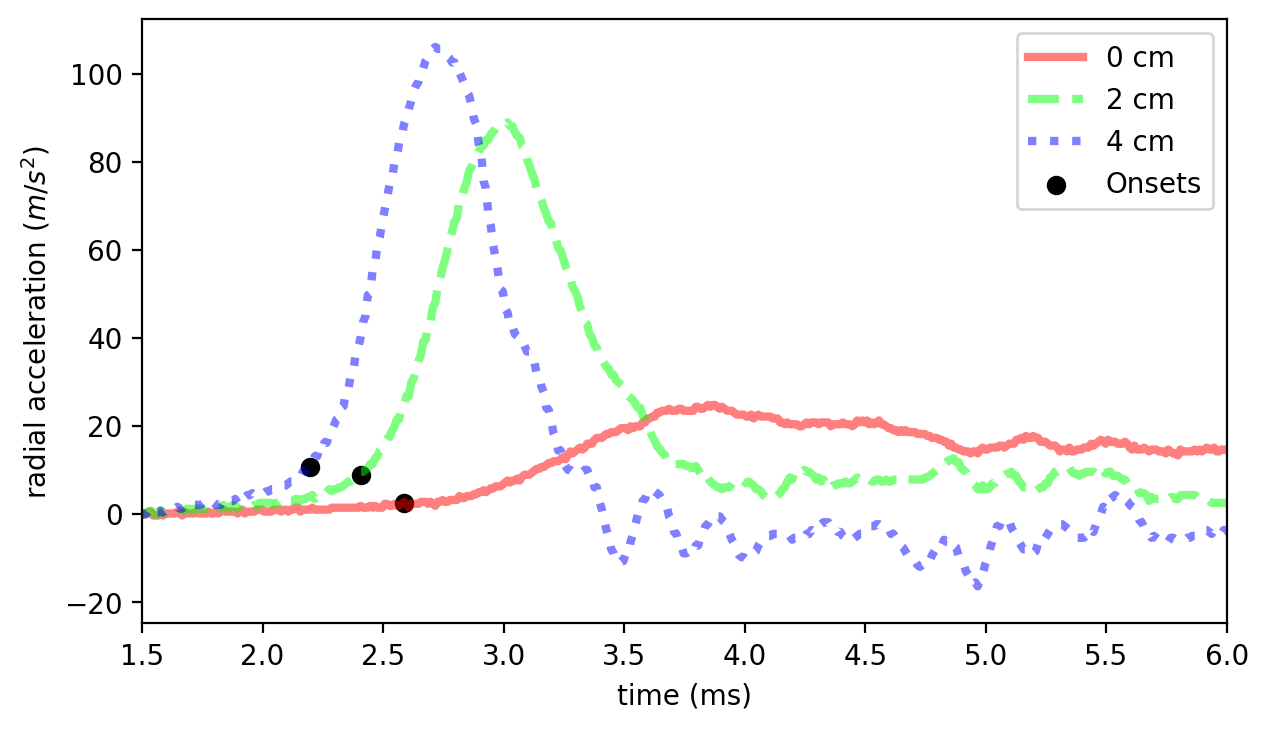

In [140]:
start = 20000
end = 30000
plt.figure(figsize=(7,4),dpi=200); 
#for i in range(3):
plt.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
plt.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
plt.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
for i in range(2):
    plt.scatter((Timex[int(onsets[1,i])+start]-.13237)*1000-10.15, onsets[0,i], marker = 'o', facecolors='k', edgecolors='k')
plt.scatter((Timex[int(onsets[1,2])+start]-.13237)*1000-10.15, onsets[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")
plt.ylabel("radial acceleration ($m/s^2$)")
plt.xlabel("time (ms)")
plt.legend()
plt.xlim(1.5,6)
plt.savefig("skin_delay.png", dpi=500)

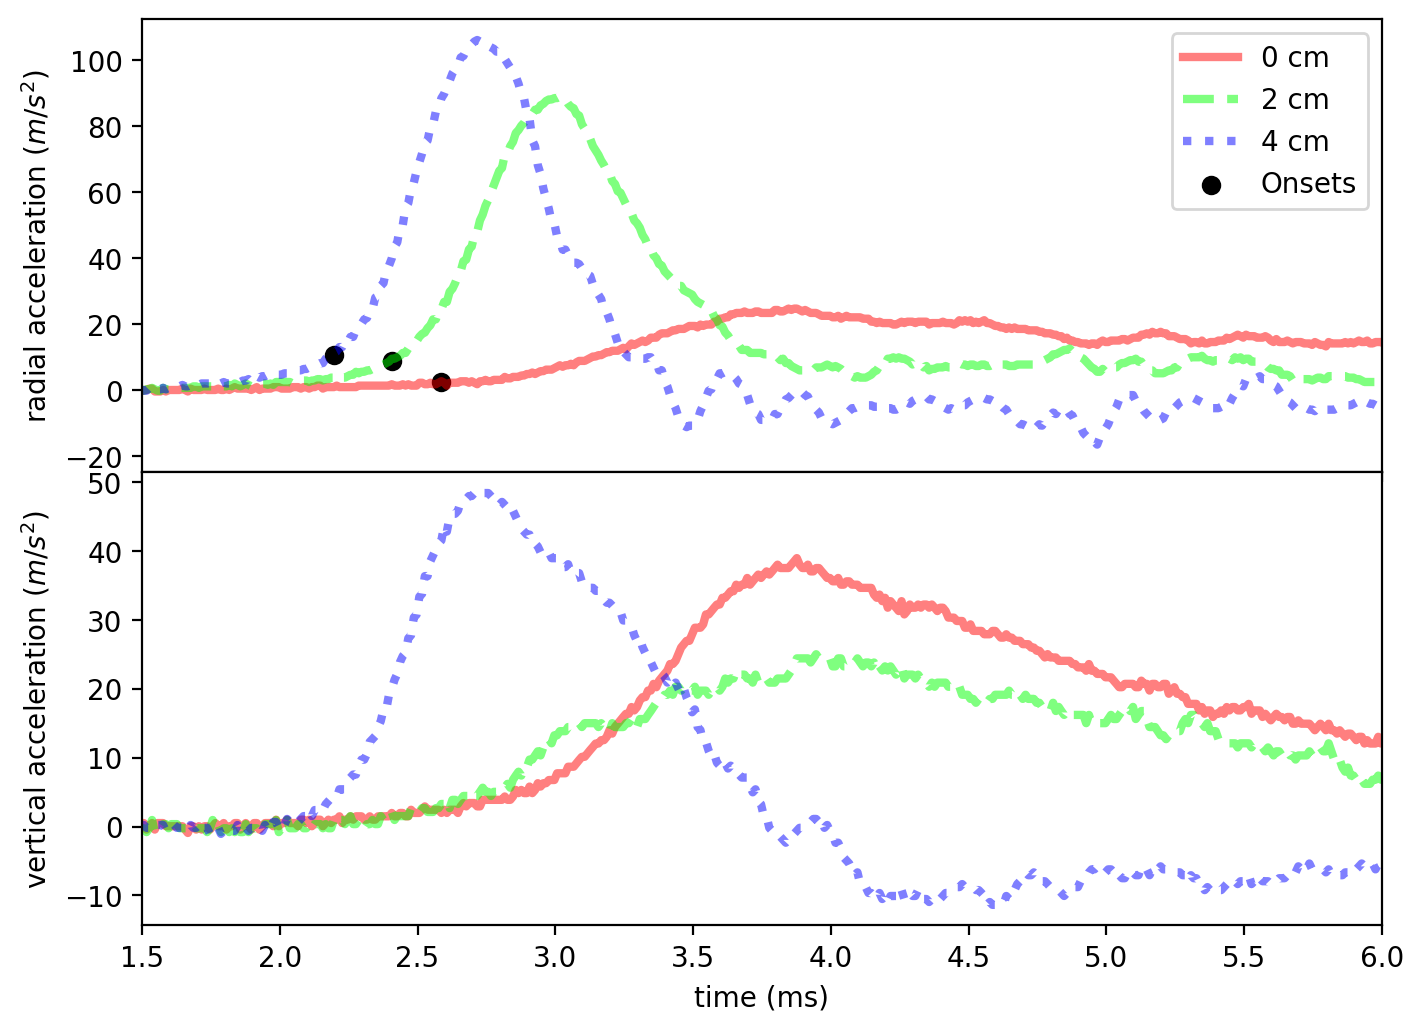

In [141]:
start = 20000
end = 30000
fig = plt.figure(figsize=(8,6),dpi=200); 
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
#for i in range(3):

ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
for i in range(2):
    ax1.scatter((Timex[int(onsets[1,i])+start]-.13237)*1000-10.15, onsets[0,i], marker = 'o', facecolors='k', edgecolors='k')
ax1.scatter((Timex[int(onsets[1,2])+start]-.13237)*1000-10.15, onsets[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")

ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[1,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[1,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3) # +2 to fix offset
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[1,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
#for i in range(2):
#    ax2.scatter((Timex[int(onsetsy[1,i])+start]-.13237)*1000-10.15, onsetsy[0,i], marker = 'o', facecolors='k', edgecolors='k')
#ax2.scatter((Timex[int(onsetsy[1,2])+start]-.13237)*1000-10.15, onsetsy[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")

ax1.set_ylabel("radial acceleration ($m/s^2$)")
ax2.set_ylabel("vertical acceleration ($m/s^2$)")
ax2.set_xlabel("time (ms)")
ax1.legend()
ax2.set_xlim(1.5,6)
plt.savefig("skin_delay.png", dpi=500)

(1.5, 6.0)

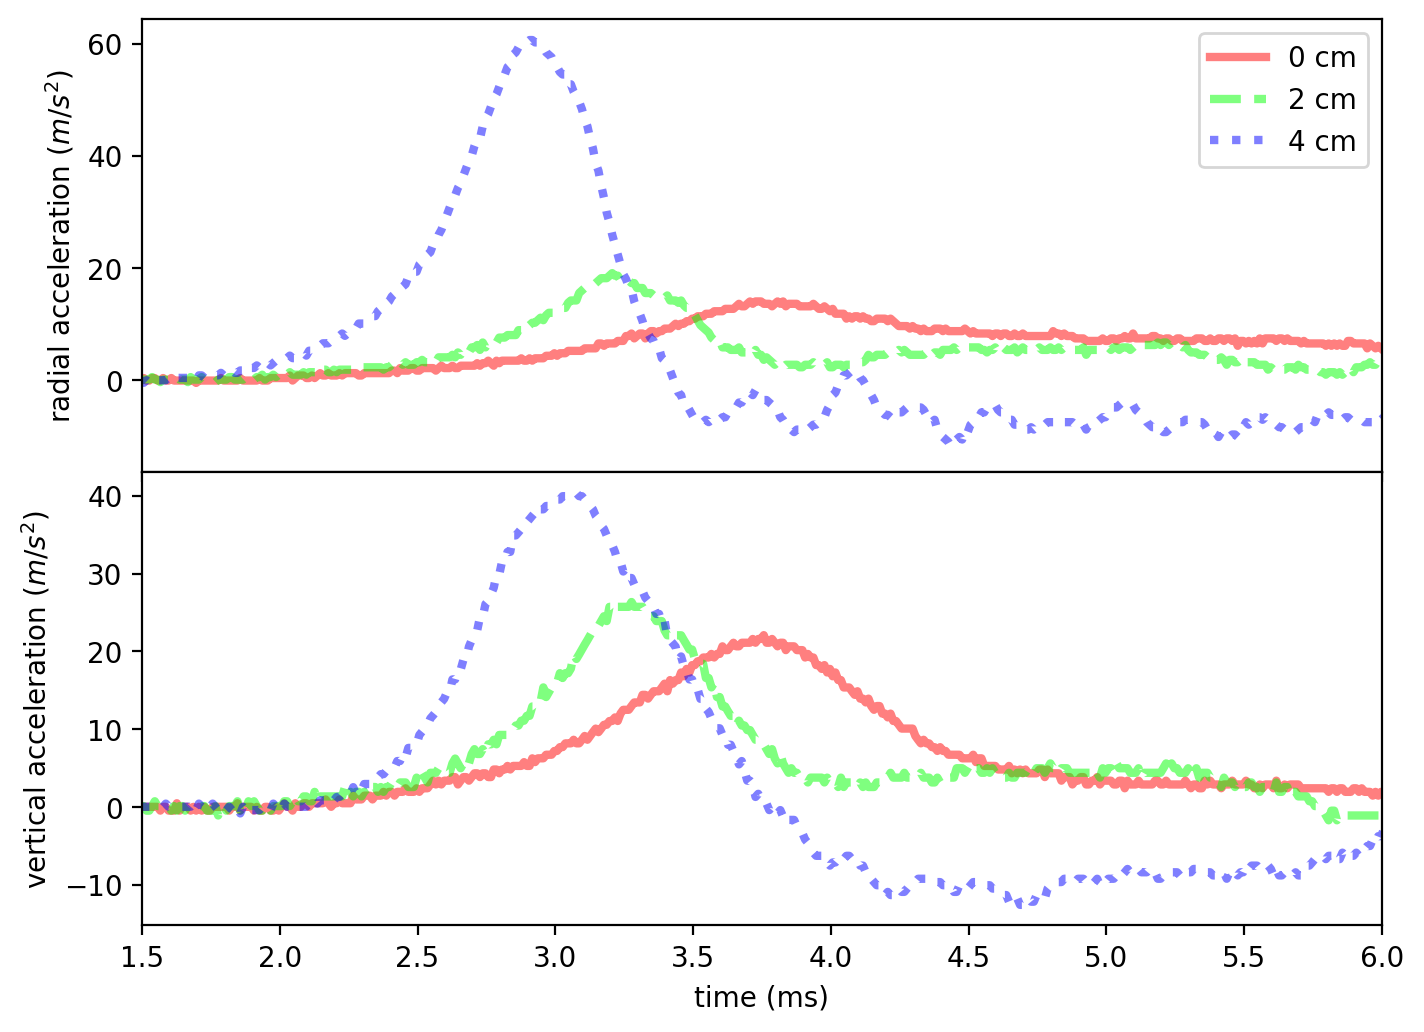

In [142]:
start = 20000
end = 30000
fig = plt.figure(figsize=(8,6),dpi=200); 
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
#for i in range(3):

ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
#for i in range(2):
#    ax1.scatter((Timex[int(onsets[1,i])+start]-.13237)*1000-10.15, onsets[0,i], marker = 'o', facecolors='k', edgecolors='k')
#ax1.scatter((Timex[int(onsets[1,2])+start]-.13237)*1000-10.15, onsets[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")

ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[1,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[1,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[1,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
#for i in range(2):
#    ax2.scatter((Timex[int(onsetsy[1,i])+start]-.13237)*1000-10.15, onsetsy[0,i], marker = 'o', facecolors='k', edgecolors='k')
#ax2.scatter((Timex[int(onsetsy[1,2])+start]-.13237)*1000-10.15, onsetsy[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")

ax1.set_ylabel("radial acceleration ($m/s^2$)")
ax2.set_ylabel("vertical acceleration ($m/s^2$)")
ax2.set_xlabel("time (ms)")
ax1.legend()
ax2.set_xlim(1.5,6)
#plt.savefig("skin_delay.png", dpi=500)

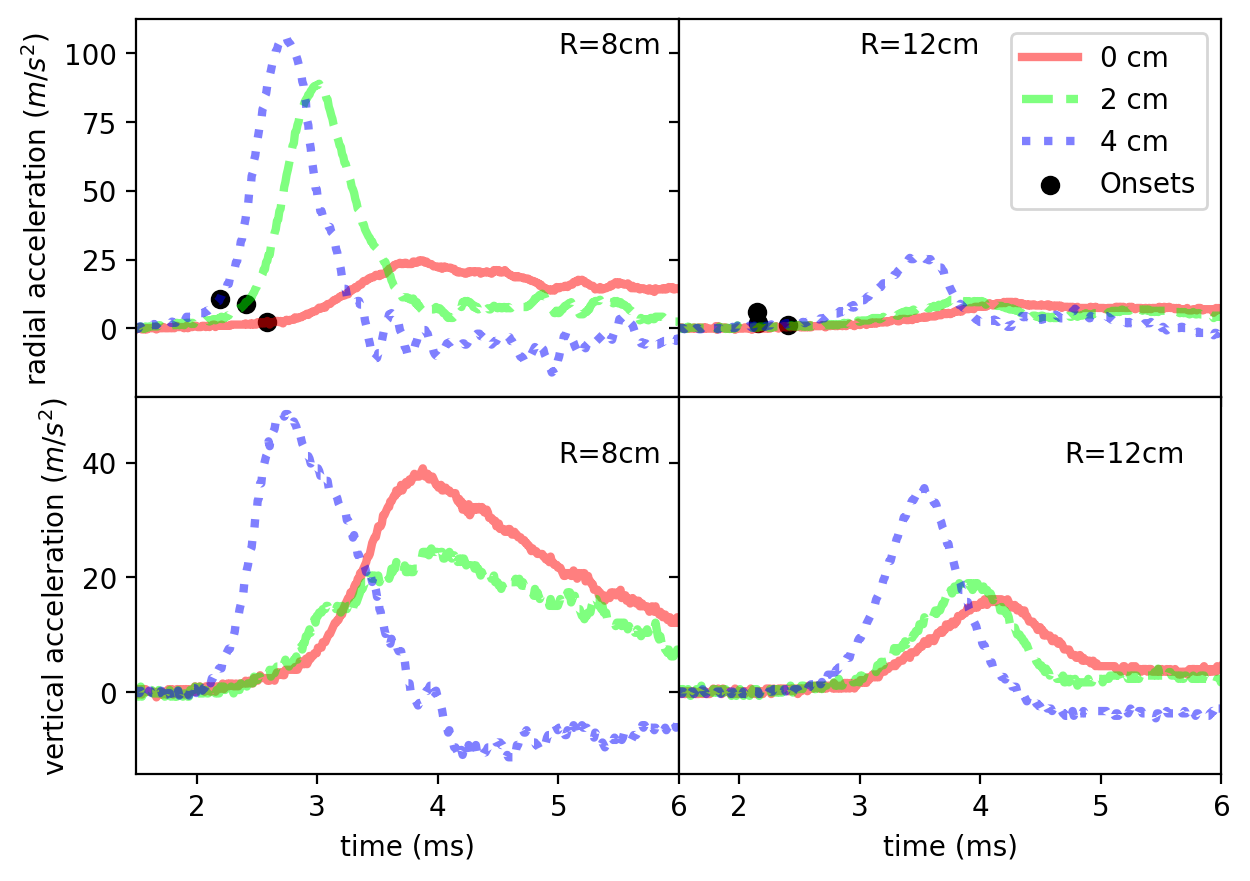

In [143]:
#make another 2x2 plot for this stuff...
start = 20000
end = 32000
fig = plt.figure(figsize=(7,5),dpi=200)
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')


#plot 8 cm stuff
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
for i in range(2):
    ax1.scatter((Timex[int(onsets[1,i])+start]-.13237)*1000-10.15, onsets[0,i], marker = 'o', facecolors='k', edgecolors='k')
ax1.scatter((Timex[int(onsets[1,2])+start]-.13237)*1000-10.15, onsets[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")

ax3.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[1,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax3.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[1,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3) # +2 to fix offset
ax3.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[1,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)

#plot 12 cm stuff
d=0
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)
for i in range(2):
    ax2.scatter((Timex[int(onsets2[1,i])+start]-.13237)*1000-10.15, onsets2[0,i], marker = 'o', facecolors='k', edgecolors='k')
ax2.scatter((Timex[int(onsets2[1,2])+start]-.13237)*1000-10.15, onsets2[0,2], marker = 'o', facecolors='k', edgecolors='k', label = "Onsets")

ax4.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[1,d,0,start:end]/100, c = (1,0,0,0.5), label = "0 cm", lw = 3)
ax4.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[1,d,1,start:end]/100, c = (0,1,0,0.5), label = "2 cm", ls = "--", lw = 3)
ax4.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[1,d,2,start:end]/100, c = (0,0,1,0.5), label = "4 cm", ls = ":", lw = 3)

ax1.set_xlim(1.5,6)
ax2.set_xlim(1.5,6)
ax1.set_ylabel("radial acceleration ($m/s^2$)")
ax3.set_ylabel("vertical acceleration ($m/s^2$)")
ax3.set_xlabel("time (ms)")
ax4.set_xlabel("time (ms)")
ax1.text(5,100,"R=8cm")
ax2.text(3,100,"R=12cm")
ax3.text(5,40,"R=8cm")
ax4.text(4.7,40,"R=12cm")
ax2.legend()
#Note that these are from 2 seperate trials and for a pulse traveling at 80 m/s a 4 cm difference is
#a 0.5 ms change in arrival time, which can be accounted for by a 3 mm change (which is below what we can 
#realistically measure) in drop height. Thus the 8 and 12 cm experiments having the same onset times is not a problem.
plt.savefig("skin_delay_tot.png", dpi=500)

(1.0, 4.0)

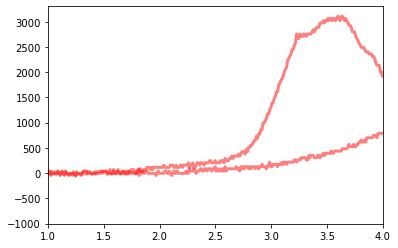

In [144]:
plt.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data8[0,d,0,start:end], c = (1,0,0,0.5), label = "0 cm", lw = 3)
plt.plot((Timex[start:end]-.13237)*1000-10.15,Accel_data12[0,d,0,start:end]-.0055, c = (1,0,0,0.5), label = "0 cm", lw = 3)
plt.xlim(1,4)

In [145]:
Vel8 = np.zeros((2,3,3,accel_xdata1.loc[1:,"Time"].size))
for i in range(2):
    for j in range(3):
        for k in range(3):
            Vel8[i,j,k,:] = integrate_accel(Accel_data8[i,j,k,:], Timex)

In [146]:
Vel12 = np.zeros((2,3,3,accel_xdata1.loc[1:,"Time"].size))
for i in range(2):
    for j in range(3):
        for k in range(3):
            Vel12[i,j,k,:] = integrate_accel(Accel_data12[i,j,k,:], Timex)

In [147]:
#convert to m/s
Vel8 = Vel8/100
Vel12 = Vel12/100

Text(0, 0.5, 'Velocity (m/s)')

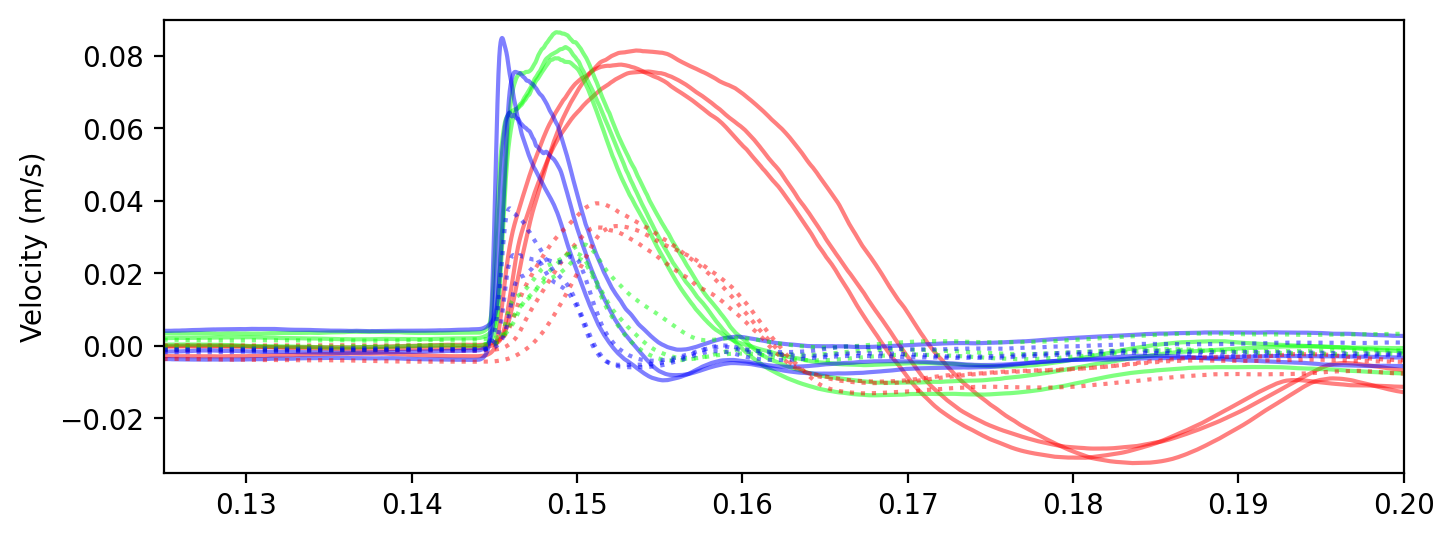

In [148]:
plt.figure(figsize=(8,3),dpi=200); 
for i in range(3):
    plt.plot(Timex[:],Vel8[0,i,0,:], c = (1,0,0,0.5))
    
for i in range(3):
    plt.plot(Timex[:],Vel8[0,i,1,:], c = (0,1,0,0.5))
    
for i in range(3):
    plt.plot(Timex[:],Vel8[0,i,2,:], c = (0,0,1,0.5))
    
for i in range(3):
    plt.plot(Timex[:],Vel12[0,i,0,:], c = (1,0,0,0.5), ls = ":")
    
for i in range(3):
    plt.plot(Timex[:],Vel12[0,i,1,:], c = (0,1,0,0.5), ls = ":")
    
for i in range(3):
    plt.plot(Timex[:],Vel12[0,i,2,:], c = (0,0,1,0.5), ls = ":")
    
plt.xlim(0.125,0.2)
plt.ylim(-.035,.09)
plt.ylabel("Velocity (m/s)")

(-3.5, 9.0)

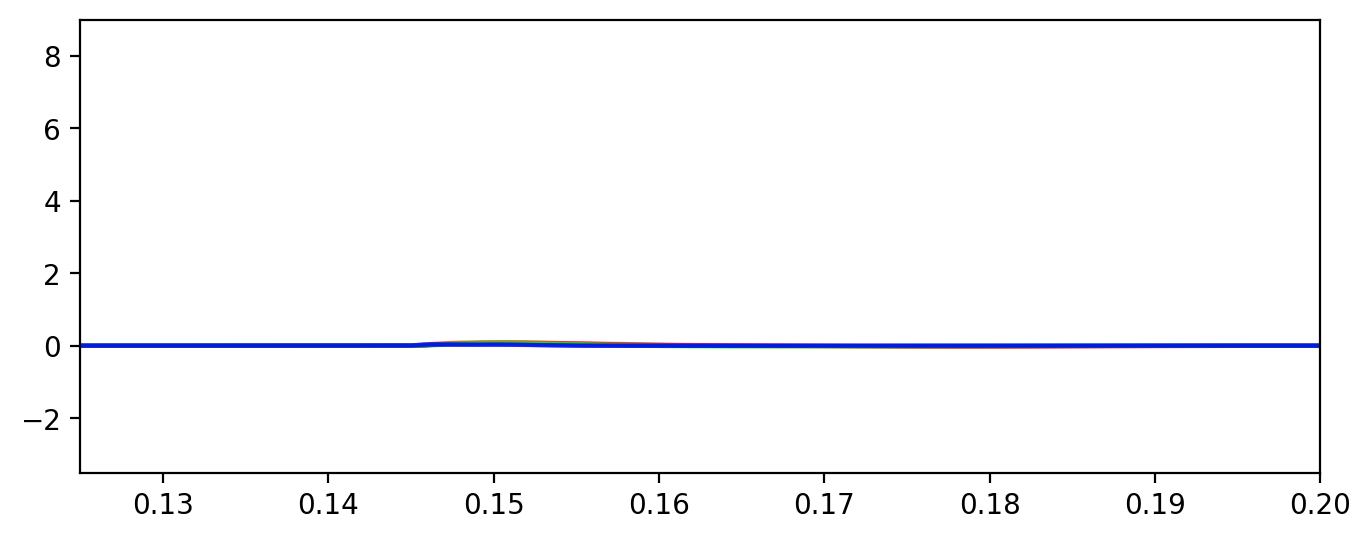

In [149]:
plt.figure(figsize=(8,3),dpi=200); 
for i in range(3):
    plt.plot(Timex[:],Vel8[1,i,0,:], c = (1,0,0,0.5))
    
for i in range(3):
    plt.plot(Timex[:],Vel8[1,i,1,:], c = (0,1,0,0.5))
    
for i in range(3):
    plt.plot(Timex[:],Vel8[1,i,2,:], c = (0,0,1,0.5))
    
plt.xlim(0.125,0.2)
plt.ylim(-3.5,9)

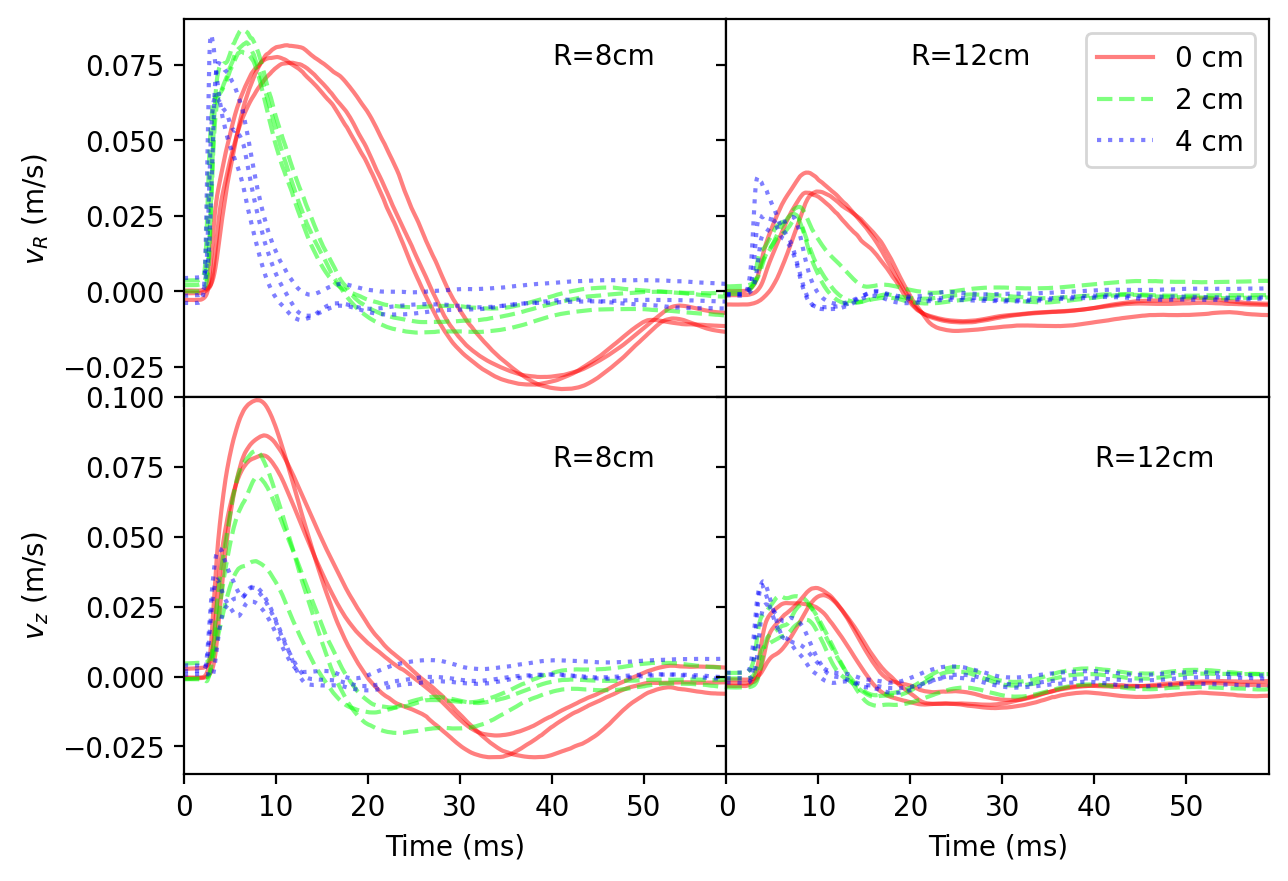

In [150]:
start = 20000
end = 32000
fig = plt.figure(figsize=(7,5),dpi=200)
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

for i in range(2):
    ax1.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[0,i,0,start:end], c = (1,0,0,0.5))
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[0,2,0,start:end], c = (1,0,0,0.5), label = "0 cm")
    
for i in range(2):
    ax1.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[0,i,1,start:end], c = (0,1,0,0.5), ls = '--')
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[0,2,1,start:end], c = (0,1,0,0.5), ls = '--', label = "2 cm")
    
for i in range(2):
    ax1.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[0,i,2,start:end], c = (0,0,1,0.5), ls = ':')
ax1.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[0,2,2,start:end], c = (0,0,1,0.5), ls = ':', label = "4 cm")
    
for i in range(2):
    ax3.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[1,i,0,start:end], c = (1,0,0,0.5))
ax3.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[1,2,0,start:end], c = (1,0,0,0.5), label = "0 cm")

for i in range(2):
    ax3.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[1,i,1,start:end], c = (0,1,0,0.5), ls = '--')
ax3.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[1,2,1,start:end], c = (0,1,0,0.5), ls = '--', label = "2 cm")
    
for i in range(2):
    ax3.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[1,i,2,start:end], c = (0,0,1,0.5), ls = ':')
ax3.plot((Timex[start:end]-.13237)*1000-10.15,Vel8[1,2,2,start:end], c = (0,0,1,0.5), ls = ':', label = "4 cm")
    
for i in range(2):
    ax2.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[0,i,0,start:end], c = (1,0,0,0.5))
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[0,2,0,start:end], c = (1,0,0,0.5), label = "0 cm")
    
for i in range(2):
    ax2.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[0,i,1,start:end], c = (0,1,0,0.5), ls = '--')
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[0,2,1,start:end], c = (0,1,0,0.5), ls = '--', label = "2 cm")
    
for i in range(2):
    ax2.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[0,i,2,start:end], c = (0,0,1,0.5), ls = ':')
ax2.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[0,2,2,start:end], c = (0,0,1,0.5), ls = ':', label = "4 cm")
    
for i in range(2):
    ax4.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[1,i,0,start:end], c = (1,0,0,0.5))
ax4.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[1,2,0,start:end], c = (1,0,0,0.5), label = "0 cm")
    
for i in range(2):
    ax4.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[1,i,1,start:end], c = (0,1,0,0.5), ls = '--')
ax4.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[1,2,1,start:end], c = (0,1,0,0.5), ls = '--', label = "2 cm")
    
for i in range(2):
    ax4.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[1,i,2,start:end], c = (0,0,1,0.5), ls = ':')
ax4.plot((Timex[start:end]-.13237)*1000-10.15,Vel12[1,2,2,start:end], c = (0,0,1,0.5), ls = ':', label = "4 cm")    
    
ax1.set_xlim(0,59)
ax2.set_xlim(0,59)

ax1.set_ylim(-0.035,0.09)
ax3.set_ylim(-0.035,0.1)

#ax1.legend()
ax2.legend()
#ax3.legend()
#ax4.legend()

ax1.set_ylabel("$v_R$ (m/s)")
ax3.set_ylabel("$v_z$ (m/s)")

ax3.set_xlabel("Time (ms)")
ax4.set_xlabel("Time (ms)")

ax1.text(40,0.075,"R=8cm")
ax2.text(20,0.075,"R=12cm")
ax3.text(40,0.075,"R=8cm")
ax4.text(40,0.075,"R=12cm")
plt.savefig("skin_vel.png", dpi=500)